# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import some additional stuff
import sys
from pandas.api.types import is_float_dtype
# [TODO] Create and import helper_functions as h

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Configure Some Verbose Parameters

In [186]:
# Set the verbosity of the Notebook to [0|1|2|..]
VERBOSE = 2

# Set display options to show all rows
pd.set_option('display.max_rows', 85)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

#### Loading the datasets

In [187]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';') 

#### Getting to know the **General Population** dataset

In [188]:
if VERBOSE > 0:
    display(azdias)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [189]:
if VERBOSE > 0:
    # Get the type of each column
    display(azdias.dtypes)

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL 

In [190]:
if VERBOSE > 0:
    display(azdias.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [191]:
if VERBOSE > 0: 
    # Get the number of unique values in each column
    unique_values = azdias.nunique()
    print("These are the number of unique values per column:\n")
    display(unique_values)

These are the number of unique values per column:



AGER_TYP                    5
ALTERSKATEGORIE_GROB        5
ANREDE_KZ                   2
CJT_GESAMTTYP               6
FINANZ_MINIMALIST           5
FINANZ_SPARER               5
FINANZ_VORSORGER            5
FINANZ_ANLEGER              5
FINANZ_UNAUFFAELLIGER       5
FINANZ_HAUSBAUER            5
FINANZTYP                   6
GEBURTSJAHR               117
GFK_URLAUBERTYP            12
GREEN_AVANTGARDE            2
HEALTH_TYP                  4
LP_LEBENSPHASE_FEIN        41
LP_LEBENSPHASE_GROB        13
LP_FAMILIE_FEIN            12
LP_FAMILIE_GROB             6
LP_STATUS_FEIN             10
LP_STATUS_GROB              5
NATIONALITAET_KZ            4
PRAEGENDE_JUGENDJAHRE      16
RETOURTYP_BK_S              5
SEMIO_SOZ                   7
SEMIO_FAM                   7
SEMIO_REL                   7
SEMIO_MAT                   7
SEMIO_VERT                  7
SEMIO_LUST                  7
SEMIO_ERL                   7
SEMIO_KULT                  7
SEMIO_RAT                   7
SEMIO_KRIT

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

##### Step 1.1.1a: Getting to know the **Feature Summary** dataset
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data.


In [192]:
if VERBOSE > 0:
    display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.1.1b: Convert Missing Value Codes to NaNs
Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [193]:
def encode_missing_values(feat_info):
    """Creates a dataframe that encodes the missing or unknown values per feature.
        
    Args:
        feat_info (df): A DF containing a summary of feature attributes and information about the codes for missing or unknown values.
    
    Return:
        A dataframe with the missing and unknown values stored as columns and per feature.
        E.g., { 
         'attribute' : [ 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ'],
                 '0' : [       '-1',                    '0',      'None'],
                 '1' : [       '-1',                    '0',         '9'],
                 '2' " [       '-1',                    '0',      'None'] }      
    """
    # Retreive the codes for the missing and unknown values
    df_codes = feat_info[['attribute', 'missing_or_unknown']].copy()

    # Remove the '[' and ']' characters from the 'missing_or_unknkown' column 
    df_codes['missing_or_unknown'] = df_codes['missing_or_unknown'].str.replace('[', '').str.replace(']', '')

    # Split the values in 'missing_or_unknown' column and expand to new columns
    df_tmp = df_codes['missing_or_unknown'].str.split(',', expand=True) # .apply(pd.to_numeric)

    # We may have some empty strings left after the splitting. 
    # Let's turn them into 'None' instead.  
    df_tmp.replace('', None, inplace=True)

    # Concatenate back into 'df_codes' and drop 'missing_or_unknown' column
    df_codes = pd.concat([df_codes, df_tmp], axis=1)
    df_codes = df_codes.drop('missing_or_unknown', axis=1)
    
    return df_codes
  

In [194]:
df_codes = encode_missing_values(feat_info)

if VERBOSE > 1:
    print(df_codes)

                attribute     0     1     2
0                AGER_TYP    -1     0  None
1    ALTERSKATEGORIE_GROB    -1     0     9
2               ANREDE_KZ    -1     0  None
3           CJT_GESAMTTYP     0  None  None
4       FINANZ_MINIMALIST    -1  None  None
5           FINANZ_SPARER    -1  None  None
6        FINANZ_VORSORGER    -1  None  None
7          FINANZ_ANLEGER    -1  None  None
8   FINANZ_UNAUFFAELLIGER    -1  None  None
9        FINANZ_HAUSBAUER    -1  None  None
10              FINANZTYP    -1  None  None
11            GEBURTSJAHR     0  None  None
12        GFK_URLAUBERTYP  None  None  None
13       GREEN_AVANTGARDE  None  None  None
14             HEALTH_TYP    -1     0  None
15    LP_LEBENSPHASE_FEIN     0  None  None
16    LP_LEBENSPHASE_GROB     0  None  None
17        LP_FAMILIE_FEIN     0  None  None
18        LP_FAMILIE_GROB     0  None  None
19         LP_STATUS_FEIN     0  None  None
20         LP_STATUS_GROB     0  None  None
21       NATIONALITAET_KZ    -1 

In [195]:
def convert_missing_values_codes_to_nan(df, df_codes):
    """
    Convert missing value codes to NaNs.
        
    Args:
        df (df): The dataframe to process.
        df_codes (df): A dataframe containing the missing and unknown values stored as columns and per feature.
    
    Return:
        Two dataframes: 
          1) the processsed dataframe with NaNs in place of missing values. 
          2) a dataframe that keeps track of the number of missing values per column.
    
    Note:
        The format of the DF that keep track of the missing values per column is:
            ['feature', 'missing_values']
    """

    # Make a copy of the incoming dataframe
    df_nan = df.copy()
    
    # Create an empty DF to count the number of missing values
    df_miss = pd.DataFrame(columns=['feature', 'missing_values'])
       
    # Iterate over the rows of the    
    for r in range(df_codes.shape[0]-1):
        feature_count = 0
        feature = df_codes.iloc[r]['attribute']
        
        # Iterate over the rows and columns
        for c in range(0, df_codes.shape[1]-1):
            if df_codes.iloc[r][c] is None:
                break;
            str_code = df_codes.iloc[r][c]
            
            # Try converting to code to integer
            is_int = True
            try:
                code = int(str_code)
            except ValueError:
                is_int = False
            
            if is_int:
                # Count the number of occurences of this 'code' in the dataset
                count = df[feature].value_counts().get(code, 0)
                if count > 0:
                    # Replace any occurrence of this 'code' with NaN
                    df_nan[feature].replace(code, np.nan, inplace=True)                
                    feature_count += count
                if VERBOSE > 2:
                    print(f"[INFO] {feature} has {count} occurrences of {code}")
            else:
                count = df[feature].value_counts().get(str_code, 0)
                if count > 0:
                    #OBSOLETE-20230804 Replace any occurrence of this 'str_code' with NaN
                    #OBSOLETE-20230804 df_nan[feature].replace(str_code, np.nan, inplace=True)
                    # Count but do not replace this occurrence now (we will handle it later)
                    feature_count += count
                if VERBOSE > 2:
                    print(f"[INFO] {feature} has {count} occurrences of {str_code}")

        # Keep track of the number of missing values
        df_miss.loc[len(df_miss)] = {'feature': feature, 'missing_values': feature_count}
                
        if VERBOSE > 2:
            print(f"[INFO] {feature} has a total of {feature_count} NaN values")
            
    return df_nan, df_miss
       

In [196]:
azdias_nan, azdias_miss = convert_missing_values_codes_to_nan(azdias, df_codes)

#### Step 1.1.2: Handle Missing Data in Each Column

##### Step 1.1.2a: Assess the Missing Data per Column
In section [1.1.1b](#step-111b-convert-missing-value-codes-to-nans) we returned a dataframe containing the number of missing values per feature. 

The first plot below shows a graphical view of these missing values. The `green` line represent a configurable threshold indicating a percentage of missing values per feature (in this case `15%`). Note that you can also display the content of this dataframe by setting the appropriate verbosity level.

The second plot shows a stair graph with a  `bin-size` configured according to the the same threshold of `15%` missing values per feature.

FYI - This is the list of features that have more than 15% (133683) of missing values:
         feature  missing_values
0       AGER_TYP          685843
11   GEBURTSJAHR          392318
40      TITEL_KZ          815562
43      ALTER_HH          236768
55   OST_WEST_KZ          168545
64  KBA05_BAUMAX          343200


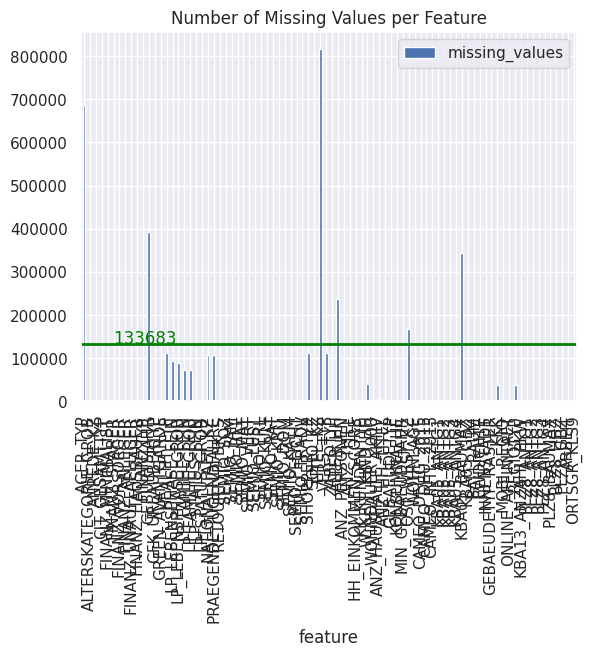

In [197]:
# Create a bar plot
plot = azdias_miss.plot(kind='bar', 
                        title='Number of Missing Values per Feature',
                        x='feature', y='missing_values')

# Visualize and list the features that have more than a certain 
# number of missing values (as a percentage of the total values)     
miss_percent = 15.0
miss_threshold = (int)(azdias_nan.shape[0] * miss_percent/100) 

print(f"FYI - This is the list of features that have more than {miss_percent:.0f}% ({miss_threshold}) of missing values:")
print(azdias_miss[azdias_miss['missing_values'] >= miss_threshold])
plot.axhline(y=miss_threshold, color= 'green', linewidth=2, 
             label=miss_threshold)
plt.text(x=5, y=miss_threshold, s=miss_threshold, color='green')

if VERBOSE > 2:
    print(azdias_miss)


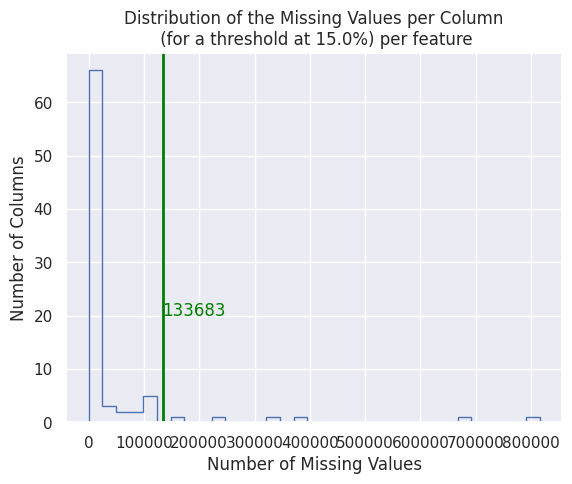

In [198]:
# Next, let's visualize the distribution of those missing values
num_bins = (int)(100/miss_percent*5)

counts, bins = np.histogram(azdias_miss['missing_values'], bins=num_bins)
plt.title(f"Distribution of the Missing Values per Column\n (for a threshold at {miss_percent}%) per feature")
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.stairs(counts, bins)
plt.axvline(x=miss_threshold, color='green', linewidth=2,)
plt.text(x=miss_threshold, y=20, s=miss_threshold, color='green')

if VERBOSE > 3:
    print(bins)

##### Step 1.1.2b: Removing the Outlier Columns
According to the 2 above graphs, we will remove all the features that have more than `miss_percent` missing values.

In [205]:
def remove_outliers_columns(df, df_miss, fi, threshold=15.0):
    """
    Remove the outlier columns from the dataset and updates the feature-information dataframe accordingly. 
        
    Args:
        df      (df): The dataset to process.
        df_miss (df): A dataframe that contains the number of missing values per column.
        fi      (df): A dataframe containing feature-info about the encoding of the dataset. 
        threshold (float, optional): The threshold specifying the acceptable percentage of missing values per column (e.g. 15.0%). Any column that has more tna 'percentage' of missing values will be dropped.
    
    Returns:
        df_roc: The dataset with removed outliers columns.
        fi_roc: The feature-information with removed feature attributes.
    """
    assert threshold >= 0.0 and threshold < 100.0
    miss_threshold = (int)(df.shape[0] * threshold/100) 
    
    # Create a copy of the incoming dataset and feature-info  
    #  Note: '_roc' stands for Removed Outliers Columns.   
    df_roc = df.copy()
    fi_roc = fi.copy() 

    # Retrieve the names of the features to remove
    drop_candidates = (df_miss[df_miss['missing_values'] >= miss_threshold])

    # Drop columns
    for f in drop_candidates.index:
        feature = drop_candidates['feature'][f]
        if VERBOSE > 0:
            print(f"[INFO] Dropping feature \'{feature}\' from the dataset and feature-info.")
        df_roc = df_roc.drop([feature], axis=1)
    
        # Remove the corresponding row in the feature summary
        fi_roc = fi_roc.drop(fi_roc[fi_roc['attribute'] == feature].index) 
        
    if VERBOSE > 0:
        print(f"\n[INFO] The shape of the dataset is now {df_roc.shape}")
        print(f"[INFO] The shape of the feat_info is now {fi_roc.shape}") 

    return df_roc, fi_roc


###################################################################
##  Remove the Outlier Columns                                   ##
###################################################################
azdias_nan_roc, feat_info_roc = remove_outliers_columns(azdias_nan, 
                                    azdias_miss, feat_info, threshold=15.0)

[INFO] Dropping feature 'AGER_TYP' from the dataset and feature-info.
[INFO] Dropping feature 'GEBURTSJAHR' from the dataset and feature-info.
[INFO] Dropping feature 'TITEL_KZ' from the dataset and feature-info.
[INFO] Dropping feature 'ALTER_HH' from the dataset and feature-info.
[INFO] Dropping feature 'OST_WEST_KZ' from the dataset and feature-info.
[INFO] Dropping feature 'KBA05_BAUMAX' from the dataset and feature-info.

[INFO] The shape of the dataset is now (891221, 79)
[INFO] The shape of the feat_info is now (79, 4)


In [ ]:
##################################
##  Remove the outlier columns  ##
##################################

# Create a copy of the current dataset and feature summary  
#  Note: '_roc' stands for Removed Outliers Columns.   
azdias_nan_roc = azdias_nan.copy()
feat_info_roc = feat_info.copy() 

# Retrieve the names of the features to remove
drop_candidates = (azdias_miss[azdias_miss['missing_values'] >= miss_threshold])

# Drop columns
for f in drop_candidates.index:
    feature = drop_candidates['feature'][f]
    if VERBOSE > 0:
        print(f"[INFO] Dropping feature \'{feature}\' from the dataset and feature-info.")
    azdias_nan_roc = azdias_nan_roc.drop([feature], axis=1)
   
    # Remove the corresponding row in the feature summary
    feat_info_roc = feat_info_roc.drop(feat_info_roc[feat_info_roc['attribute'] == 
                                                     feature ].index)    
    
if VERBOSE > 0:
    print(f"\n[INFO] The shape of the dataset is now {azdias_nan_roc.shape}")
    print(f"[INFO] The shape of the feat_info is now {feat_info_roc.shape}") 


#### Discussion 1.1.2c: Missing Data in Each Column
In section [1.1.2a](#step-112a-assess-the-missing-data-per-column) we created two graphs to investigate how missing data were distributed  across different columns of the dataset.

With the 1st graph, we observe that a few features have a large amount of missing values. By setting a threshold value at 15% of the total number of values in a column, we identify 6 features **('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'OST_WEST_KZ' 'KBA05_BAUMAX')** that accumulate large amounts of missing values (2nd graph). We therefore decided to consider these features as outliers, and to remove them from the current dataset.          

#### Step 1.1.3: Assess Missing Data in Each Row
Here we perform a similar assessment of missing data for the rows of the dataset to figure out how much data is missing in each row. 

##### Step 1.1.3a: How much data is missing in each row
In this section, we compute the number of missing data in each row and we plot the corresponding distribution.

In [ ]:
######################################################
##  Compute the number of missing data in each row  ##
######################################################

nans_per_row = azdias_nan_roc.isna().sum(axis=1)
if VERBOSE > 2:
    print(nans_per_row)

# Let's plot the distribution of the number of missing values per row
# to get a bettre grasp on the trend
num_bins = azdias_nan_roc.shape[1]
counts, bins = np.histogram(nans_per_row, bins=num_bins)
plt.title(f"Distribution of the Missing Values per Row")
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.stairs(counts, bins)
plt.axvline(x=25, color='green', linewidth=2,)
plt.text(x=25, y=25000, s=25, color='green')


##### Step 1.1.3b: Divide the dataset into two subsets
From the above distribution, we can clearly see two groups of rows with different numbers of missing values. Let's define a `threshold` for missing values and split the dataset into two subsets: 
- one for data points that are above this threshold and,
- a second subset for points below that threshold.

In [ ]:
########################################
##  Divide the data into two subsets  ##
########################################

# Define a threshold for the split
threshold = 25

# Subset with less than 'threshold' NaNs
azdias_nan_roc_lo_miss = azdias_nan_roc[azdias_nan_roc.isnull().sum(axis=1) <= threshold]

# Subset with more than 'threshold' NaNs
azdias_nan_roc_hi_miss = azdias_nan_roc[azdias_nan_roc.isnull().sum(axis=1) > threshold]

if VERBOSE > 1:
    print(f"The shape of the 'low'  subset is {azdias_nan_roc_lo_miss.shape}")
    print(f"The shape of the 'high' subset is {azdias_nan_roc_hi_miss.shape}")

##### Step 1.1.3c: Compare the distribution of values among columns of the two subsets
In order to know decide a way to handle the outlier rows, we can compare the distribution of data values of a few columns in the two subsets, and see how much they differ.

We start by finding and selecting five columns with zero or low number of missing values. For information,  we selected the following 5 features:
   - **ANZ_PERSONEN**       (Number of adults in household)
   - **HH_EINKOMMEN_SCORE** (Estimated household net income)
   - **WOHNLAGE**           (Neighborhood quality (or rural flag))
   - **LP_STATUS_FEIN**     (Social status, fine scale)
   - **ARBEIT**             (Share of unemployment in community)

In [ ]:
############################################################
##  Print columns with very low number of missing values  ##
############################################################

miss_percent = 1.0
miss_threshold = (int)(azdias_nan_roc.shape[0] * miss_percent/100) 
print(f"FYI - This is the list of features that have less than {miss_percent:.0f}% ({miss_threshold}) of missing values:")
print(azdias_miss[azdias_miss['missing_values'] <= miss_threshold].sort_values(by='missing_values'))

In [ ]:
def plot_countplot_grid(df0, df1, features):
    """
    Plot a grid comparing a list of feature counts of observations between two dataframes.

    Args:
        df0 (df): A dataframe with low numbers of missing values.
        df1 (df): A dataframe with higher number of missing values.
        feature (string): A list of feature column names to compare.
    """
    sns.set_theme(style="darkgrid")
    
    grid_cols = 2 # Always
    grid_rows = len(features)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 4*grid_rows), sharey=True)
    fig.suptitle('Counts of observations per feature\n LOW (left) vs HIGH (right) Number of Missing Values')
  
    for f in range(axes.shape[0]):
        # 1st Dataframe
        sns.countplot(ax=axes[f, 0], data=df0, x=df0[features[f]])
        # 2nd Dataframe
        sns.countplot(ax=axes[f, 1], data=df1, x=df1[features[f]])


In [ ]:
################################################################################
##  Compare the distribution of values for at least five columns where there  ##
##              are no or few missing values, between the two subsets.        ##
################################################################################

# The selected 5 features are: 
#   ANZ_PERSONEN       = Number of adults in household
#   HH_EINKOMMEN_SCORE = Estimated household net income
#   WOHNLAGE           = Neighborhood quality (or rural flag)
#   LP_STATUS_FEIN     = Social status, fine scale
#   ARBEIT             = Share of unemployment in community

plot_countplot_grid(azdias_nan_roc_lo_miss, 
                    azdias_nan_roc_hi_miss, 
                    ["ANZ_PERSONEN", "HH_EINKOMMEN_SCORE", "WOHNLAGE", "LP_STATUS_FEIN", "ARBEIT"])

#### Discussion 1.1.3: Assess Missing Data in Each Row

The above comparison shows two trends:
- the distributions of the features with many missing values if often non-existent due to lack of data and, 
- a distribution exists, its shape looks different from the one with few or no missing values but the amplitude of this difference is only a small fraction of the one with few or no missing values.

This suggest that we can can go and drop the rows from the second group as they won't significantly impact the analysis. Therefore, **we will continue our analysis using just the subset of the data with few or no missing values.**

### Step 1.2: Select and Re-Encode Features

```
Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!
```

#### Step 1.2.1a: Identify the Various Data Types
We can retrieve the various data types used in the feature columns by looking at 
the third column of the feature summary (`feat_info_roc`). 

In [ ]:
#####################################################################
##  Identify the number of different features used by the dataset  ## 
##           and get the counts of each data                       ##
#####################################################################
data_types = feat_info_roc['type'].value_counts().to_dict()

print(f"They are {len(data_types)} different data types in the dataset and the usage is as follows:")
for key, value in data_types.items():
    print(f"\t- {key} \t is used by {value:2d} feature(s)")

#### Step 1.2.1b: Numeric and Inteval Data Handling
The numeric and interval data features will be kept without changes.

#### Step 1.2.1c: Re-Encode Categorical Features
In this step, we identify which of the categorical variables are binary, which are
multi-level, and which one needs to be re-encoded.

[INFO] At this point of the data wrangling, the current raw dataset is referred
to as: 'azdias_nan_roc_lo_miss'.

In [ ]:
##########################################
##  Identify the categorical variables  ##
##########################################

# List the categorical variables
mixed_features = feat_info_roc[feat_info_roc['type'] == 'categorical'].copy()

# Add a column with the number of unique values per feature and populate it
mixed_features['unique_values'] = 0

for index, row in mixed_features.iterrows():
    attrib_name = row['attribute']
    if attrib_name in azdias_nan_roc_lo_miss:
        num_unique = azdias_nan_roc_lo_miss[attrib_name].nunique()
        if VERBOSE > 2:
            print(f"Attribute {attrib_name} has {num_unique} unique values")
        mixed_features.loc[index, 'unique_values'] = num_unique

# Sort the dataframe by the 'unique_values' column 
mixed_features = mixed_features.sort_values(by='unique_values', ascending=False)

print(f"This is a summary of the categorical variables and the number of unique values:")
mixed_features


**From the above above summary, we identify 3 groups of categorical data**
- A group of 3  binary (two-level) categoricals that we are going to re-encode as as number, unless they already take numeric values.
- A group of 5 multi-level categoricals with 3 to 6 unique values. Given The relatively low number of levels, one can consider to encode these values with
a one-hot-encoder.
- A group of 5 multi-level categoricals with 7 to 45 unique values that we are simply going to drop.

In [ ]:
#############################################################################
##  Re-encoding of the categorical variable that are kept for the analysis ##
#############################################################################

df_g2 =   (mixed_features.loc[mixed_features['unique_values'] == 2])

df_g3_to_6 = mixed_features.loc[
            (mixed_features['unique_values'] >= 3) &
            (mixed_features['unique_values'] <= 6)]
           
# Re-encode members of the group2 (if needed)                   
for index, row in df_g2.iterrows():
    attrib_name = row['attribute']
    column_type = azdias_nan_roc_lo_miss[attrib_name].dtype
    # Assess that the feature is a sub dtype of np.number
    if not np.issubdtype(column_type, np.number):
        print("[HOUSTON, We have a problem!!]")
        print(f"\tPleased handle the type of the feature \'{attrib_name}\' properly as it is currently not a sub-type of np.number." )
        sys.exit()

# Re-encode members of the group3_to_6 
#  (here we use pandas.get_dummies() but OneHotEncoder() from Scikit-learn is also an option)
for index, row in df_g3_to_6.iterrows():
    attrib_name = row['attribute']
    column_type = azdias_nan_roc_lo_miss[attrib_name].dtype
    # Assess that the feature is a sub dtype of np.number
    if not np.issubdtype(column_type, np.number):
        print("[HOUSTON, We have a problem!!]")
        print(f"\tPleased handle the type of the feature \'{attrib_name}\' properly as it is currently not a sub-type of np.number." )
        sys.exit()
    ohe = pd.get_dummies(azdias_nan_roc_lo_miss[attrib_name], prefix=attrib_name)
    if VERBOSE > 2:
        print(f"The One-Hot-Encoded version of feature \'{attrib_name}\' is:")
        print(ohe.head())
        print(f"--------------------------------------------------------")


#### Discussion 1.2.1d: Re-Encode Categorical Features
The above section 1.2.1c identified 3 groups of categorical data:
- A group of 3  binary (two-level) categoricals.
    - This group was kept and did not require any re-encoding because all the 
    feature columns were already a sub-type of np.number.    
- A group of 5 multi-level categoricals with 3 to 6 unique values.
    - This group was prepared for a one-hot-encoding but it was not yet included into the dataset because it adds a fair amount of 29 columns. I may add some of these columns later, espacially: Customer-Journey-Typology (CJT_GESAMTTYP), 
Financial type for individual (FINANZTYP) or the Consumer pattern (KK_KUNDENTYP). However, for the time being, I decided to do a fist submission of the poject as is.
- A group of 5 multi-level categoricals with 7 to 45 unique values. 
    - All the features of this group were simply dropped as they would introduce too many columns in the analysis.


#### Step 1.2.2a: Engineer Mixed-Type Features
In this step, we identify the 'mixed' variables and handle them appropriately for inclusion in the analysis.

[INFO] At this point of the data wrangling, the current raw dataset is referred to as: 'azdias_nan_roc_lo_miss'.

In [ ]:
####################################
##  Identify the mixed variables  ##
####################################

# List the mixed variables
mixed_features = feat_info_roc[feat_info_roc['type'] == 'mixed'].copy()

# Add a column with the number of unique values per feature and populate it
mixed_features['unique_values'] = 0

for index, row in mixed_features.iterrows():
    attrib_name = row['attribute']
    if attrib_name in azdias_nan_roc_lo_miss:
        num_unique = azdias_nan_roc_lo_miss[attrib_name].nunique()
        if VERBOSE > 2:
            print(f"Attribute {attrib_name} has {num_unique} unique values")
        mixed_features.loc[index, 'unique_values'] = num_unique

# Sort the dataframe by the 'unique_values' column 
mixed_features = mixed_features.sort_values(by='unique_values', ascending=False)

print(f"This is a summary of the mixed variables and the number of unique values:")
mixed_features

In [ ]:
####################################################################
##  Investigate 'CAMEO_INTL_2015' and engineer two new variables  ##
####################################################################

# [INFO] The 'CAMEO_INTL_2015' feature combines information on two axes: 
#  wealth and life stage. This code breaks up the two-digit codes by their
#  'tens'-place and 'ones'-place digits into two new ordinal variables named
#  'CAMEO_INTL_2015_WEALTH' and 'CAMEO_INTL_2015_LIFE_STAGE'. Futhermore, for
#  the purposes of this project, it is OK to just treat them as their raw
#  numeric values.

# Create a copy of the current dataset and feature summary
azdias_nan_roc_lo_miss_mixed = azdias_nan_roc_lo_miss.copy()
feat_info_roc_mixed = feat_info_roc.copy()
 
# Substitute the remaining "XX' strings of feature 'CAMEO_INTL_2015' by NaN
azdias_nan_roc_lo_miss_mixed.loc[azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015'] == 'XX', 'CAMEO_INTL_2015'] = np.nan
# And convert the column to float values
azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015'] = azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015'].astype(float)

# Add and populate two new columns in the dataset
#OBSOLETE azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015_LIVE_STAGE'] = np.nan
azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015_LIFE_STAGE'] = (azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015'].mod(10))

#OBSOLETE azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015_WEALTH'] = np.nan
azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015_WEALTH'] = (azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015'] -
                                                          azdias_nan_roc_lo_miss_mixed['CAMEO_INTL_2015_LIFE_STAGE'])

# Drop the obsoleted 'CAMEO_INTL_2015' feature from the dataset
azdias_nan_roc_lo_miss_mixed = azdias_nan_roc_lo_miss_mixed.drop('CAMEO_INTL_2015', axis=1)

# Accordingly, drop 'CAMEO_INTL_2015' and add two new rows to feature-info 
feat_info_roc_mixed = feat_info_roc.drop(feat_info_roc_mixed[feat_info_roc_mixed['attribute'] == 
                                                     'CAMEO_INTL_2015' ].index)
new_row_1 = {'attribute'         : 'CAMEO_INTL_2015_LIVE_STAGE',
             'information_level' : 'microcell_rr4',
             'type'              : 'mixed',
             'missing_or_unknown': '[NaN]'}
new_row_2 = {'attribute'         : 'CAMEO_INTL_2015_WEALTH',
             'information_level' : 'microcell_rr4',
             'type'              : 'mixed',
             'missing_or_unknown': '[NaN]'}
feat_info_roc_mixed.loc[len(feat_info_roc_mixed)] = new_row_1
feat_info_roc_mixed.loc[len(feat_info_roc_mixed)] = new_row_2


#### Discussion 1.2.2b: Engineer Mixed-Type Features
At this stage of the data wrangling, we were left with 3 features marked as 'mixed' 
namely the Wealth / Life Stage Typology (CAMEO_INTL_2015), the neighborhood quality (WOHNLAGE) and the building type within the PLZ8 region (PLZ8_BAUMAX). 

- The 'CAMEO_INTL_2015' which contained combined information on two axes (wealth and life stage), was processed and broke down into a 'CAMEO_INTL_2015_WEALTH' feature with ordinal codes between 1 and 5, and a 'CAMEO_INTL_2015_LIVE_STAGE' feature with ordinal codes between 10 and 50 (by steps of 10).

- The 'PRAEGENDE_JUGENDJAHRE' which contained combined information on three dimensions (generation by decade, movement, and nation) was not processed because this feature had already been dropped during the analysis performed in Step [1.1.2b](#step-112b-removing-the-outlier-columns) and accoding to the discussion in section [1.1.3c](#step-113c-compare-the-distribution-of-values-among-columns-of-the-two-subsets). 

- Finally, the last two features () were kept for the final anlaysis but they were not processed during this phase because they had already beeen wrangled in section [1.1.1b](#step-111b-convert-missing-value-codes-to-nans) by the function `convert_missing_values_codes_to_nan(df, df_codes)` where their data types were turned from 'mixed' to 'float64' types.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
######################################################
##  Finalize the last two features of type 'object' ##
######################################################

sel_objects = list(azdias_nan_roc_lo_miss_mixed.select_dtypes(include='object'))

print(f"[INFO] At this stage of the data wrangling, we are left with {azdias_nan_roc_lo_miss_mixed.shape[1]} features.")
print(f"       We still need to do some processing on 2 of them as they are of data type 'object'.")
print(f"       These two features of data type 'object' are:")
print(f"         {sel_objects}")

# Substitute the remaining "X' strings of feature 'CAMEO_DEUG_2015' by NaN
azdias_nan_roc_lo_miss_mixed.loc[azdias_nan_roc_lo_miss_mixed['CAMEO_DEUG_2015'] == 'X', 'CAMEO_DEUG_2015'] = np.nan
if VERBOSE > 2:
    print(f"This is to verify that they are no 'X' sting left in the feature encoding.")
    x_test = azdias_nan_roc_lo_miss_mixed[azdias_nan_roc_lo_miss_mixed['CAMEO_DEUG_2015'] == 'X']
    print(f"\t {x_test.shape}")

# And convert the column 'CAMEO_DEUG_2015' to float values
azdias_nan_roc_lo_miss_mixed['CAMEO_DEUG_2015'] = azdias_nan_roc_lo_miss_mixed['CAMEO_DEUG_2015'].astype(float)    

# Substitute the remaining "XX' strings of feature 'CAMEO_DEU_2015' by NaN
azdias_nan_roc_lo_miss_mixed.loc[azdias_nan_roc_lo_miss_mixed['CAMEO_DEU_2015'] == 'XX', 'CAMEO_DEU_2015'] = np.nan
if VERBOSE > 2:
    print(f"This is to verify that they are no 'XX' sting left in the feature encoding.")
    xx_test = azdias_nan_roc_lo_miss_mixed[azdias_nan_roc_lo_miss_mixed['CAMEO_DEU_2015'] == 'XX']
    print(f"\t {xx_test.shape}")

# And convert the column 'CAMEO_DEU_2015' from Hex string to Float values
azdias_nan_roc_lo_miss_mixed['CAMEO_DEU_2015']  = azdias_nan_roc_lo_miss_mixed['CAMEO_DEU_2015'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)


In [ ]:
#############################################################
##  Display a Summary of the Current State of the Dataset  ##
#############################################################

print(f"[INFO] At this stage of the data wrangling, the dataset is ready for the analysis.")
print(f"       The dataset is based on the subset with few or no missing values and it consists of: ")
print(f"           {azdias_nan_roc_lo_miss_mixed.shape[0]} rows x {azdias_nan_roc_lo_miss_mixed.shape[1]} columns")

# Select the column names which are of data type 'float'
the_floats = list(azdias_nan_roc_lo_miss_mixed.select_dtypes(include='float'))
the_ints   = list(azdias_nan_roc_lo_miss_mixed.select_dtypes(include='integer'))
print(f"           They are {len(the_floats)} features of type \'float64\' ")
print(f"           They are {len(the_ints)} features of type \'int64\' ")

# List the feature types using 'groupby'
col_types = azdias_nan_roc_lo_miss_mixed.columns.to_series().groupby(azdias_nan_roc_lo_miss_mixed.dtypes).groups
print(f"       The list of \'int64\' and \'float64\' type of features is:")
print(f"           {col_types}")


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
def clean_data(df, fi):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Args: 
        df (df) Demographics DataFrame
        fi (df) Feature Information summarizing the encoding of the dataset 
    
    Return: 
        A trimmed and cleaned demographics DataFrame
    """
    
    # STEP-1: Convert Missing Value Codes to NaNs
    df_codes = encode_missing_values(fi)
    df_nan, df_miss = convert_missing_values_codes_to_nan(df, df_codes)
       
    # STEP-2: Remove selected columns
    #  The removal is based on a 'threshod' that specifies the acceptable percentage
    #  of missing values per column (e.g. 15%).     
    df_roc, fi_roc = remove_outliers_columns(df_nan, df_miss, threshold=15)

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    return df_nan
    
    

In [ ]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
azdias_clean = clean_data(azdias, feat_info)
azdias_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [ ]:
# Apply feature scaling to the general population demographics data.



### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.



In [ ]:
# Investigate the variance accounted for by each principal component.



In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.